
Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   bytes_in             282 non-null    int64              
 1   bytes_out            282 non-null    int64              
 2   creation_time        282 non-null    datetime64[ns, UTC]
 3   end_time             282 non-null    datetime64[ns, UTC]
 4   src_ip               282 non-null    object             
 5   src_ip_country_code  282 non-null    object             
 6   protocol             282 non-null    object             
 7   response_code        282 non-null    int64              
 8   dst_port             282 non-null    int64              
 9   dst_ip               282 non-null    object             
 10  rule_names           282 non-null    object             
 11  observation_name     282 non-null    object             
 12  source_met

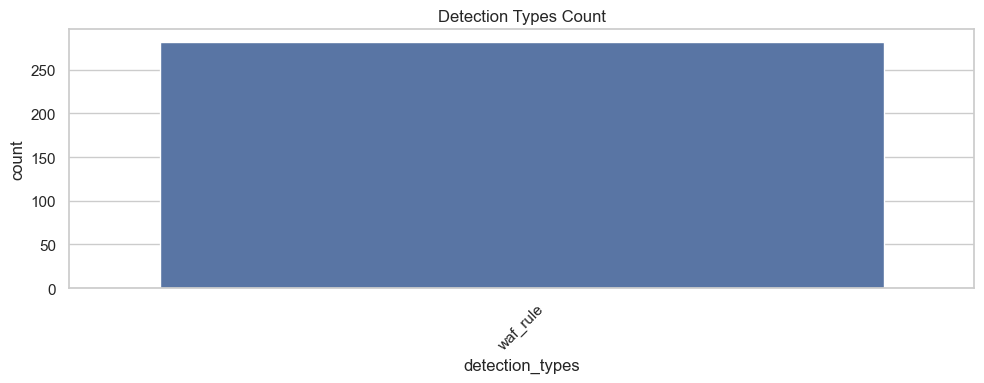

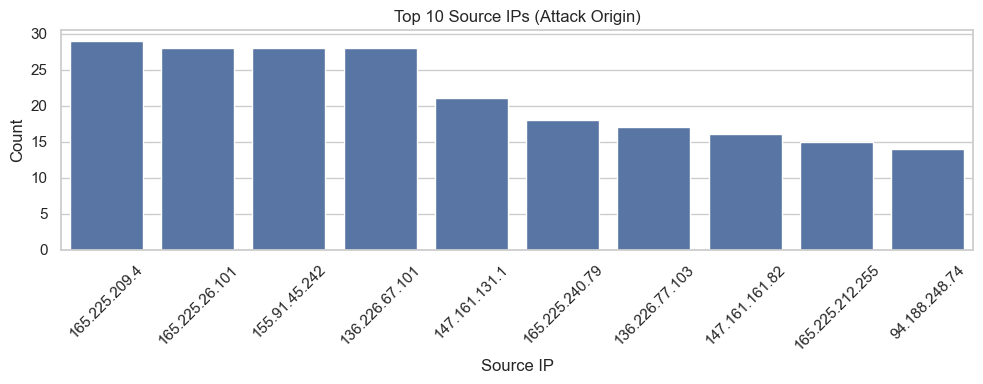

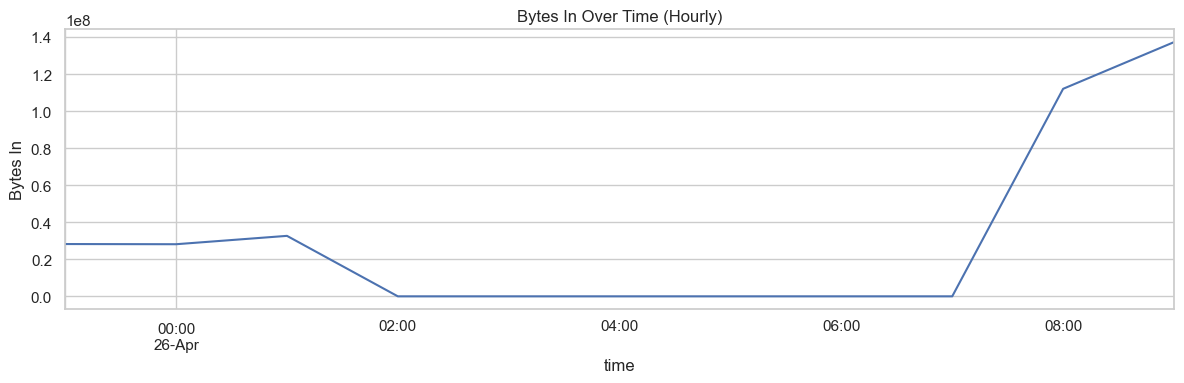


Label Distribution:
 is_suspicious
1    282
Name: count, dtype: int64

Train Label Distribution:
 is_suspicious
1    225
0     40
Name: count, dtype: int64
Test Label Distribution:
 is_suspicious
1    57
0    10
Name: count, dtype: int64

Confusion Matrix:
 [[10  0]
 [ 0 57]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        57

    accuracy                           1.00        67
   macro avg       1.00      1.00      1.00        67
weighted avg       1.00      1.00      1.00        67

Accuracy Score: 1.0


In [2]:
# =======================================
# SUSPICIOUS WEB THREAT DETECTION PROJECT
# =======================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Set visualization style
sns.set(style="whitegrid")

# -------------------------------
# STEP 1: LOAD & INSPECT THE DATA
# -------------------------------
file_path = "../data/CloudWatch_Traffic_Web_Attack.csv"
df = pd.read_csv(file_path)

# Clean column names
df = df.rename(columns={
    "response.code": "response_code",
    "source.meta": "source_meta",
    "source.name": "source_name"
})

# Convert date columns to datetime
df["creation_time"] = pd.to_datetime(df["creation_time"])
df["end_time"] = pd.to_datetime(df["end_time"])
df["time"] = pd.to_datetime(df["time"])

# Check basic info
print("\nData Info:")
df.info()

# Check for null values
print("\nMissing Values:\n", df.isnull().sum())

# --------------------------------------
# STEP 2: EDA - EXPLORATORY DATA ANALYSIS
# --------------------------------------
plt.figure(figsize=(10, 4))
sns.countplot(data=df, x="detection_types", order=df["detection_types"].value_counts().index)
plt.title("Detection Types Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Top 10 Source IPs
top_sources = df["src_ip"].value_counts().head(10)
plt.figure(figsize=(10, 4))
sns.barplot(x=top_sources.index, y=top_sources.values)
plt.title("Top 10 Source IPs (Attack Origin)")
plt.xlabel("Source IP")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Traffic Over Time
plt.figure(figsize=(12, 4))
df.set_index("time")["bytes_in"].resample("h").sum().plot(title="Bytes In Over Time (Hourly)")
plt.ylabel("Bytes In")
plt.tight_layout()
plt.show()

# ----------------------------------
# STEP 3: FEATURE ENGINEERING
# ----------------------------------
# Binary label for suspicious activity

df["is_suspicious"] = df["detection_types"].apply(lambda x: 1 if "waf_rule" in x.lower() else 0)
print("\nLabel Distribution:\n", df["is_suspicious"].value_counts())

# Add duration feature

df["duration"] = (df["end_time"] - df["creation_time"]).dt.total_seconds()

# Encode categorical features
le = LabelEncoder()
for col in ["protocol", "src_ip_country_code"]:
    df[col + "_encoded"] = le.fit_transform(df[col])

# -----------------------------
# STEP 4: BALANCING THE DATASET
# -----------------------------
# Simulate 50 normal (non-suspicious) entries
normal_data = pd.DataFrame({
    "bytes_in": np.random.randint(500, 5000, 50),
    "bytes_out": np.random.randint(500, 5000, 50),
    "duration": np.random.uniform(30, 600, 50),
    "protocol_encoded": np.random.choice(df["protocol_encoded"].unique(), 50),
    "src_ip_country_code_encoded": np.random.choice(df["src_ip_country_code_encoded"].unique(), 50),
    "is_suspicious": 0
})

# Prepare real suspicious data
suspicious_data = df[df["is_suspicious"] == 1][[
    "bytes_in", "bytes_out", "duration",
    "protocol_encoded", "src_ip_country_code_encoded", "is_suspicious"
]]

# Combine and shuffle
final_df = pd.concat([suspicious_data, normal_data], ignore_index=True).sample(frac=1, random_state=42)

# -----------------------------
# STEP 5: MODEL TRAINING
# -----------------------------
X = final_df.drop("is_suspicious", axis=1)
y = final_df["is_suspicious"]

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Train Random Forest
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# -----------------------------
# STEP 6: EVALUATION
# -----------------------------
print("\nTrain Label Distribution:\n", y_train.value_counts())
print("Test Label Distribution:\n", y_test.value_counts())

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred, labels=[0, 1]))
print("\nClassification Report:\n", classification_report(y_test, y_pred, labels=[0, 1]))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

import joblib

# Save model
joblib.dump(model, "suspicious_traffic_model.pkl")

def predict_traffic(input_data):
    """
    input_data: DataFrame with same features used for training
    Returns: Predicted label (0 = normal, 1 = suspicious)
    """
    return model.predict(input_data)
